In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Precios Fertilizantes

In [196]:
precios_fertilizantes = pd.read_csv('data\precios_fertilizantes.csv', delimiter=';', encoding='latin1')

precios_fertilizantes['date'] = pd.to_datetime(precios_fertilizantes['date'])
precios_fertilizantes.set_index('date', inplace=True)


In [197]:
# Obtener período de análisis:
años_precios_fertilizantes = precios_fertilizantes.index.year.unique()
primer_año_análisis = str(años_precios_fertilizantes.min())
último_año_análisis = str(años_precios_fertilizantes.max())

# Revisar período de análisis:
print('Primer año de análisis: ', primer_año_análisis)
print('Último año de análisis: ', último_año_análisis)

Primer año de análisis:  2013
Último año de análisis:  2023


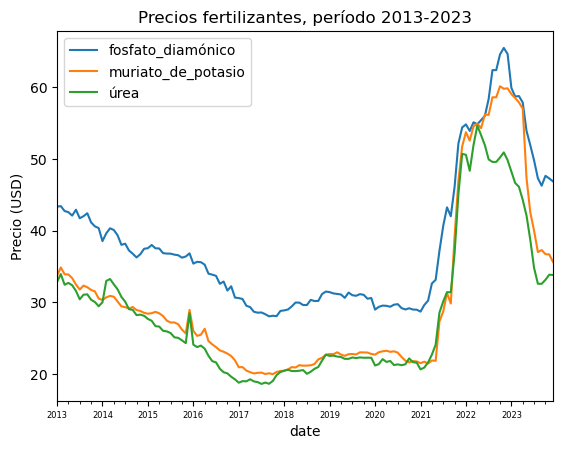

In [198]:
# Graficar precios de fertilizantes:
precios_fertilizantes.plot()
plt.title(f"Precios fertilizantes, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Precio (USD)")
plt.xticks(size=6)
plt.show()

### Inflación

In [199]:
inflación_mensual = pd.read_csv('data\inflación_mensual.csv')

inflación_mensual['Inflación mensual general'] = inflación_mensual['Inflación mensual general'].str.replace(',', '.')

inflación_mensual_nacional = inflación_mensual\
    .rename(columns={
        'Mes': 'date',
        'Inflación mensual general': 'inflación_mensual'
        })\
    .astype({
        'date': 'datetime64[ns]',
        'inflación_mensual': 'float'
        })\
    [inflación_mensual['Región'] == 'NACIONAL']\
    .drop(columns=['Año', 'Región'])\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]

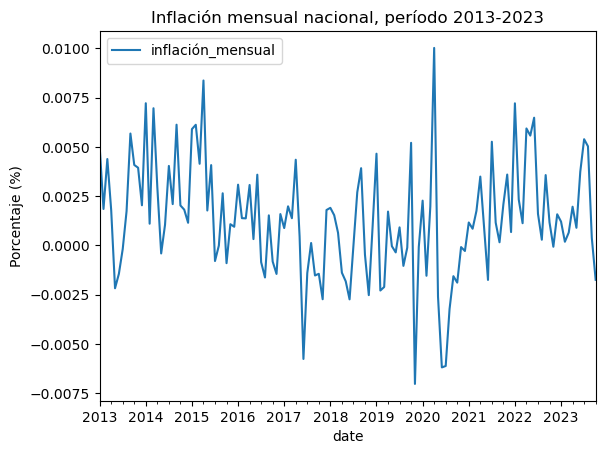

In [200]:
inflación_mensual_nacional.plot()
plt.title(f"Inflación mensual nacional, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Porcentaje (%)")
plt.show()

### Precios combustibles

In [201]:
precios_combustibles = pd.read_excel('data\precios-combustibles.xlsx')

precios_combustibles['date'] = pd.to_datetime(precios_combustibles['date'])
precios_combustibles = precios_combustibles\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]


In [202]:
index_inferencias = pd.date_range(start='2013-01', end='2015-01', freq='M')

dict_precios_inferidos = {}

for col in precios_combustibles.columns:
    dict_precios_inferidos[col] = [precios_combustibles[col].iloc[0] for x in range(len(index_inferencias))]

precios_inferidos = pd.DataFrame(
    dict_precios_inferidos,
    index=index_inferencias
)

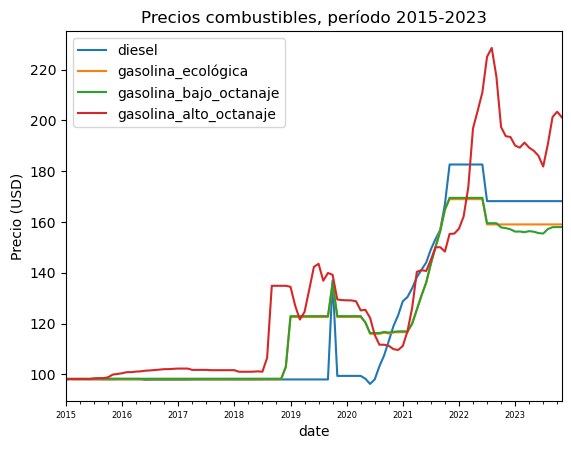

In [203]:
# Graficar precios de combustibles:
precios_combustibles.plot()
plt.title(f"Precios combustibles, período 2015-{último_año_análisis}")
plt.ylabel("Precio (USD)")
plt.xticks(size=6)
plt.show()

### Precios WTI

In [204]:
precios_wti = pd.read_excel('data\precios_wti.xlsx')

# Convertir las columnas a formato largo (melt)
precios_wti = precios_wti.melt(
    id_vars=["Year"],
    var_name="Month",value_name="precio_wti"
    )

# Crear la columna 'Fecha' a partir de 'Year' y 'Month'
precios_wti['date'] = pd.to_datetime(precios_wti['Year'].astype(str) + '-' + precios_wti['Month'].str[0:3] + '-01')

# Seleccionar solo las columnas 'Fecha' y 'Price':
precios_wti = precios_wti[['date', 'precio_wti']]

# Ordenar por 'date' y establecer como índice; filtrar por período de análisis:
precios_wti = precios_wti\
    .sort_values('date')\
    .reset_index(drop=True)\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]

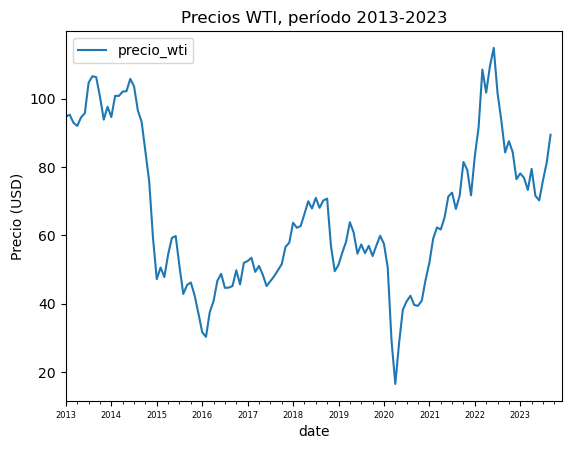

In [205]:
# Graficar:
precios_wti.plot()
plt.title(f"Precios WTI, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Precio (USD)")
plt.xticks(size=6)
plt.show()

### Datos climáticos

In [230]:
# URL del archivo JSON
url = "https://cckpapi.worldbank.org/cckp/v1/cru-x0.5_timeseries_pr,tas_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean/ECU?_format=json"

# Leer el archivo JSON desde la URL y cargarlo en un DataFrame de pandas
datos_climáticos_bm = pd.read_json(url)\
    .drop(columns=['metadata'])\
    .dropna()


# Inicializa el diccionario de salida:
dict_datos_climáticos = {}

# Itera sobre el índice del DataFrame:
for i in datos_climáticos_bm.index:
    # Extrae los valores directamente y aplana la lista anidada
    flattened_values = [v for sublist in datos_climáticos_bm.loc[i].values[0].values() for v in sublist.values()]
    # Asigna los valores al diccionario:
    dict_datos_climáticos[i] = flattened_values

# Crear una serie de fechas entre fecha_inicial y fecha_final:
serie_fechas = pd.date_range(start='1901-01', end='2023-01', freq='M')

datos_climáticos = pd.DataFrame(
    dict_datos_climáticos,
    index=serie_fechas
    )\
    .rename(columns={'pr': 'precipitación_media_mm', 'tas':'temp_media_Celsius'})\
    [primer_año_análisis:último_año_análisis]

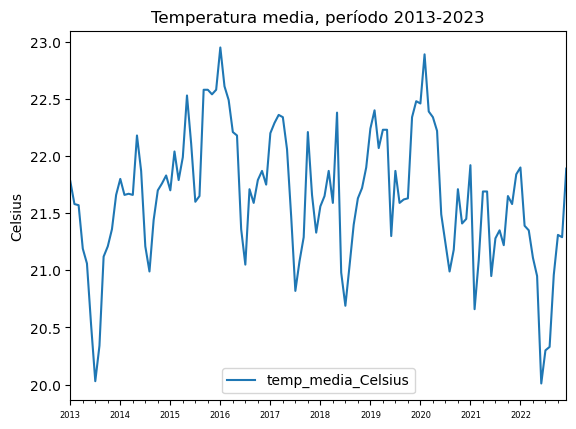

In [232]:
# Graficar temperatura media:
datos_climáticos['temp_media_Celsius'].plot()
plt.title(f"Temperatura media, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Celsius")
plt.legend()
plt.xticks(size=6)
plt.show()

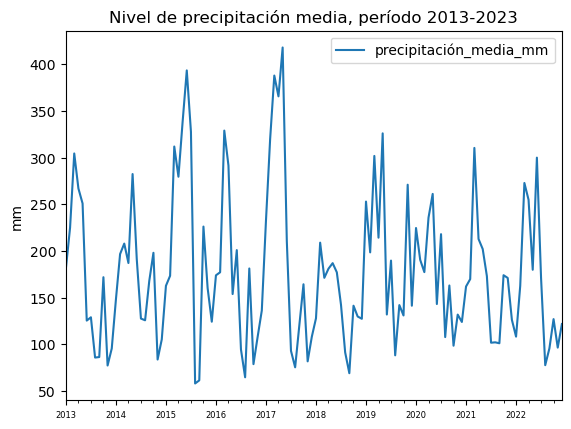

In [233]:
# Graficar precipitaciones:
datos_climáticos['precipitación_media_mm'].plot()
plt.title(f"Nivel de precipitación media, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("mm")
plt.legend()
plt.xticks(size=6)
plt.show()
plt.show()

In [240]:
# Datos de temperatura y precipitaciones SIPA:
datos_climáticos_sipa = pd.read_excel(r'data\temperatura-precipitacion-sipa.xlsx', sheet_name='temperatura_precipitación')

datos_climáticos_sipa.head(5)

,Año,Mes,Estación,Provincia,Cantón,Precipitación (mm),Temperatura promedio (°C)
0,2000,Enero,Inguincho,Imbabura,Otavalo,115.2,9.2
1,2000,Febrero,Inguincho,Imbabura,Otavalo,113.3,9.2
2,2000,Marzo,Inguincho,Imbabura,Otavalo,121.7,9.8
3,2000,Abril,Inguincho,Imbabura,Otavalo,290.7,10.1
4,2000,Mayo,Inguincho,Imbabura,Otavalo,253.5,10.0


In [241]:
# Agregar datos para obtener valores medios nacionales:
datos_climáticos_sipa = datos_climáticos_sipa\
    .rename(columns={'Precipitación (mm)': 'precipitación_media_mm', 'Temperatura promedio (°C)':'temp_media_Celsius'})\
    .groupby(['Año', 'Mes'])\
    [['precipitación_media_mm', 'temp_media_Celsius']]\
    .mean()\
    .reset_index()

In [242]:
# Diccionario para mapear meses por sus equivalentes numéricos:
meses = {
    'Enero': '01',
    'Febrero': '02',
    'Marzo': '03',
    'Abril': '04',
    'Mayo': '05',
    'Junio': '06',
    'Julio': '07',
    'Agosto': '08',
    'Septiembre': '09',
    'Octubre': '10',
    'Noviembre': '11',
    'Diciembre': '12'
}

# Crear la columna de fecha combinando 'Año' y 'Mes':
datos_climáticos_sipa['date'] = pd.to_datetime(
    datos_climáticos_sipa['Año'].astype(str) + \
    '-' + \
    datos_climáticos_sipa['Mes'].map(meses)
    )+ pd.offsets.MonthEnd(0)  # Ajusta al último día del mes

datos_climáticos_sipa = datos_climáticos_sipa\
    .sort_values(by='date')\
    .set_index('date')\
    .drop(columns=['Año', 'Mes'])\
    [primer_año_análisis:'2022']

,precipitación_media_mm,temp_media_Celsius
date,,
2013-01-31,146.433645,19.569663
2013-02-28,196.636735,19.515000
2013-03-31,195.757282,19.706098
2013-04-30,130.854902,19.584337
2013-05-31,124.729412,19.252564
...,...,...
2022-08-31,55.979167,18.887500
2022-09-30,60.120833,19.279167
2022-10-31,115.829167,19.666667


Correlación precipitación_media_mm:  0.697450024430516
Correlación temp_media_Celsius:  0.5489464438969055


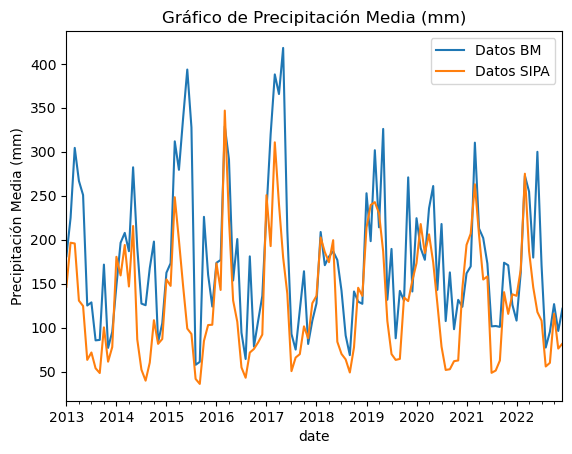

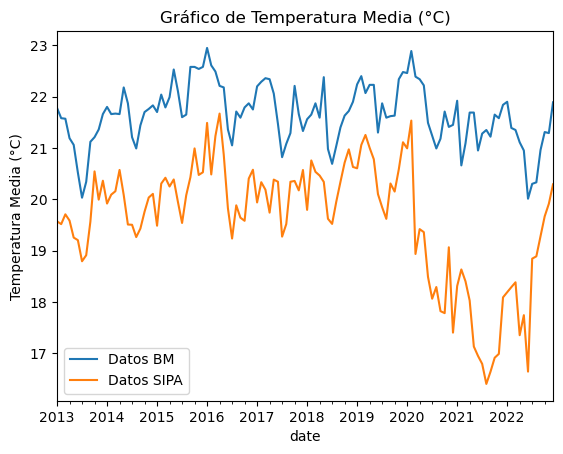

In [255]:
# Revisamos correlaciones entre fuentes de datos distintas:
for col in ('precipitación_media_mm', 'temp_media_Celsius'):
    print(f"Correlación {col}: ", datos_climáticos[col].corr(datos_climáticos_sipa[col][:'2022']))

# Gráfica para precipitación_media_mm
datos_climáticos['precipitación_media_mm'].plot(label='Datos BM')
datos_climáticos_sipa['precipitación_media_mm'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Precipitación Media (mm)')
plt.xlabel('date')
plt.ylabel('Precipitación Media (mm)')
plt.show()

# Gráfica para temp_media_Celsius
datos_climáticos['temp_media_Celsius'].plot(label='Datos BM')
datos_climáticos_sipa['temp_media_Celsius'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Temperatura Media (°C)')
plt.xlabel('date')
plt.ylabel('Temperatura Media (°C)')
plt.show()


### Datos de producción agrícola

In [256]:
producción_agrícola = pd.read_excel(r'data\superficie-producción.xlsx', sheet_name='superficie_y_producción')

In [257]:
producción_agrícola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24109 entries, 0 to 24108
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Año                        24109 non-null  int64 
 1   Producto                   24109 non-null  object
 2   Provincia                  24109 non-null  object
 3   Tipo                       24108 non-null  object
 4   Superficie Plantada (ha)   16784 non-null  object
 5   Superficie Cosechada (ha)  16031 non-null  object
 6   Producción (toneladas)     16039 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


In [268]:
producción_agrícola = producción_agrícola.replace(to_replace={'*': np.nan, '.': np.nan, ',':np.nan, '..':np.nan})

vars_producción_num = ['Superficie Plantada (ha)', 'Superficie Cosechada (ha)', 'Producción (toneladas)']

producción_agrícola[vars_producción_num] = producción_agrícola[vars_producción_num].astype(float)

In [278]:
producción_agrícola_anual = producción_agrícola\
    .groupby(['Año', 'Producto'])\
    [vars_producción_num]\
    .sum()\
    .reset_index()\
    .sort_values(
        by=['Producto', 'Año'],
        ascending=[True, True]
        )\
    .reset_index()\
    .drop(columns=['index'])

producción_agrícola_anual

,Año,Producto,Superficie Plantada (ha),Superficie Cosechada (ha),Producción (toneladas)
0,2016,Aguacate (Fruta Fresca),5578.747094,3615.003935,16118.412963
1,2017,Aguacate (Fruta Fresca),6535.790321,4653.320957,20995.353872
2,2018,Aguacate (Fruta Fresca),6163.534979,4309.299423,18232.009219
3,2019,Aguacate (Fruta Fresca),7125.428808,4415.202078,26407.862931
4,2020,Aguacate (Fruta Fresca),7629.670620,4822.454406,20352.480106
...,...,...,...,...,...
635,2018,Yuca (Raíz Fresca),14261.933188,12756.414289,76892.484808
636,2019,Yuca (Raíz Fresca),14822.892778,13601.086543,69863.160501
637,2020,Yuca (Raíz Fresca),15410.466982,14961.597912,64272.997694
638,2021,Yuca (Raíz Fresca),18630.860138,17475.255145,96210.495189


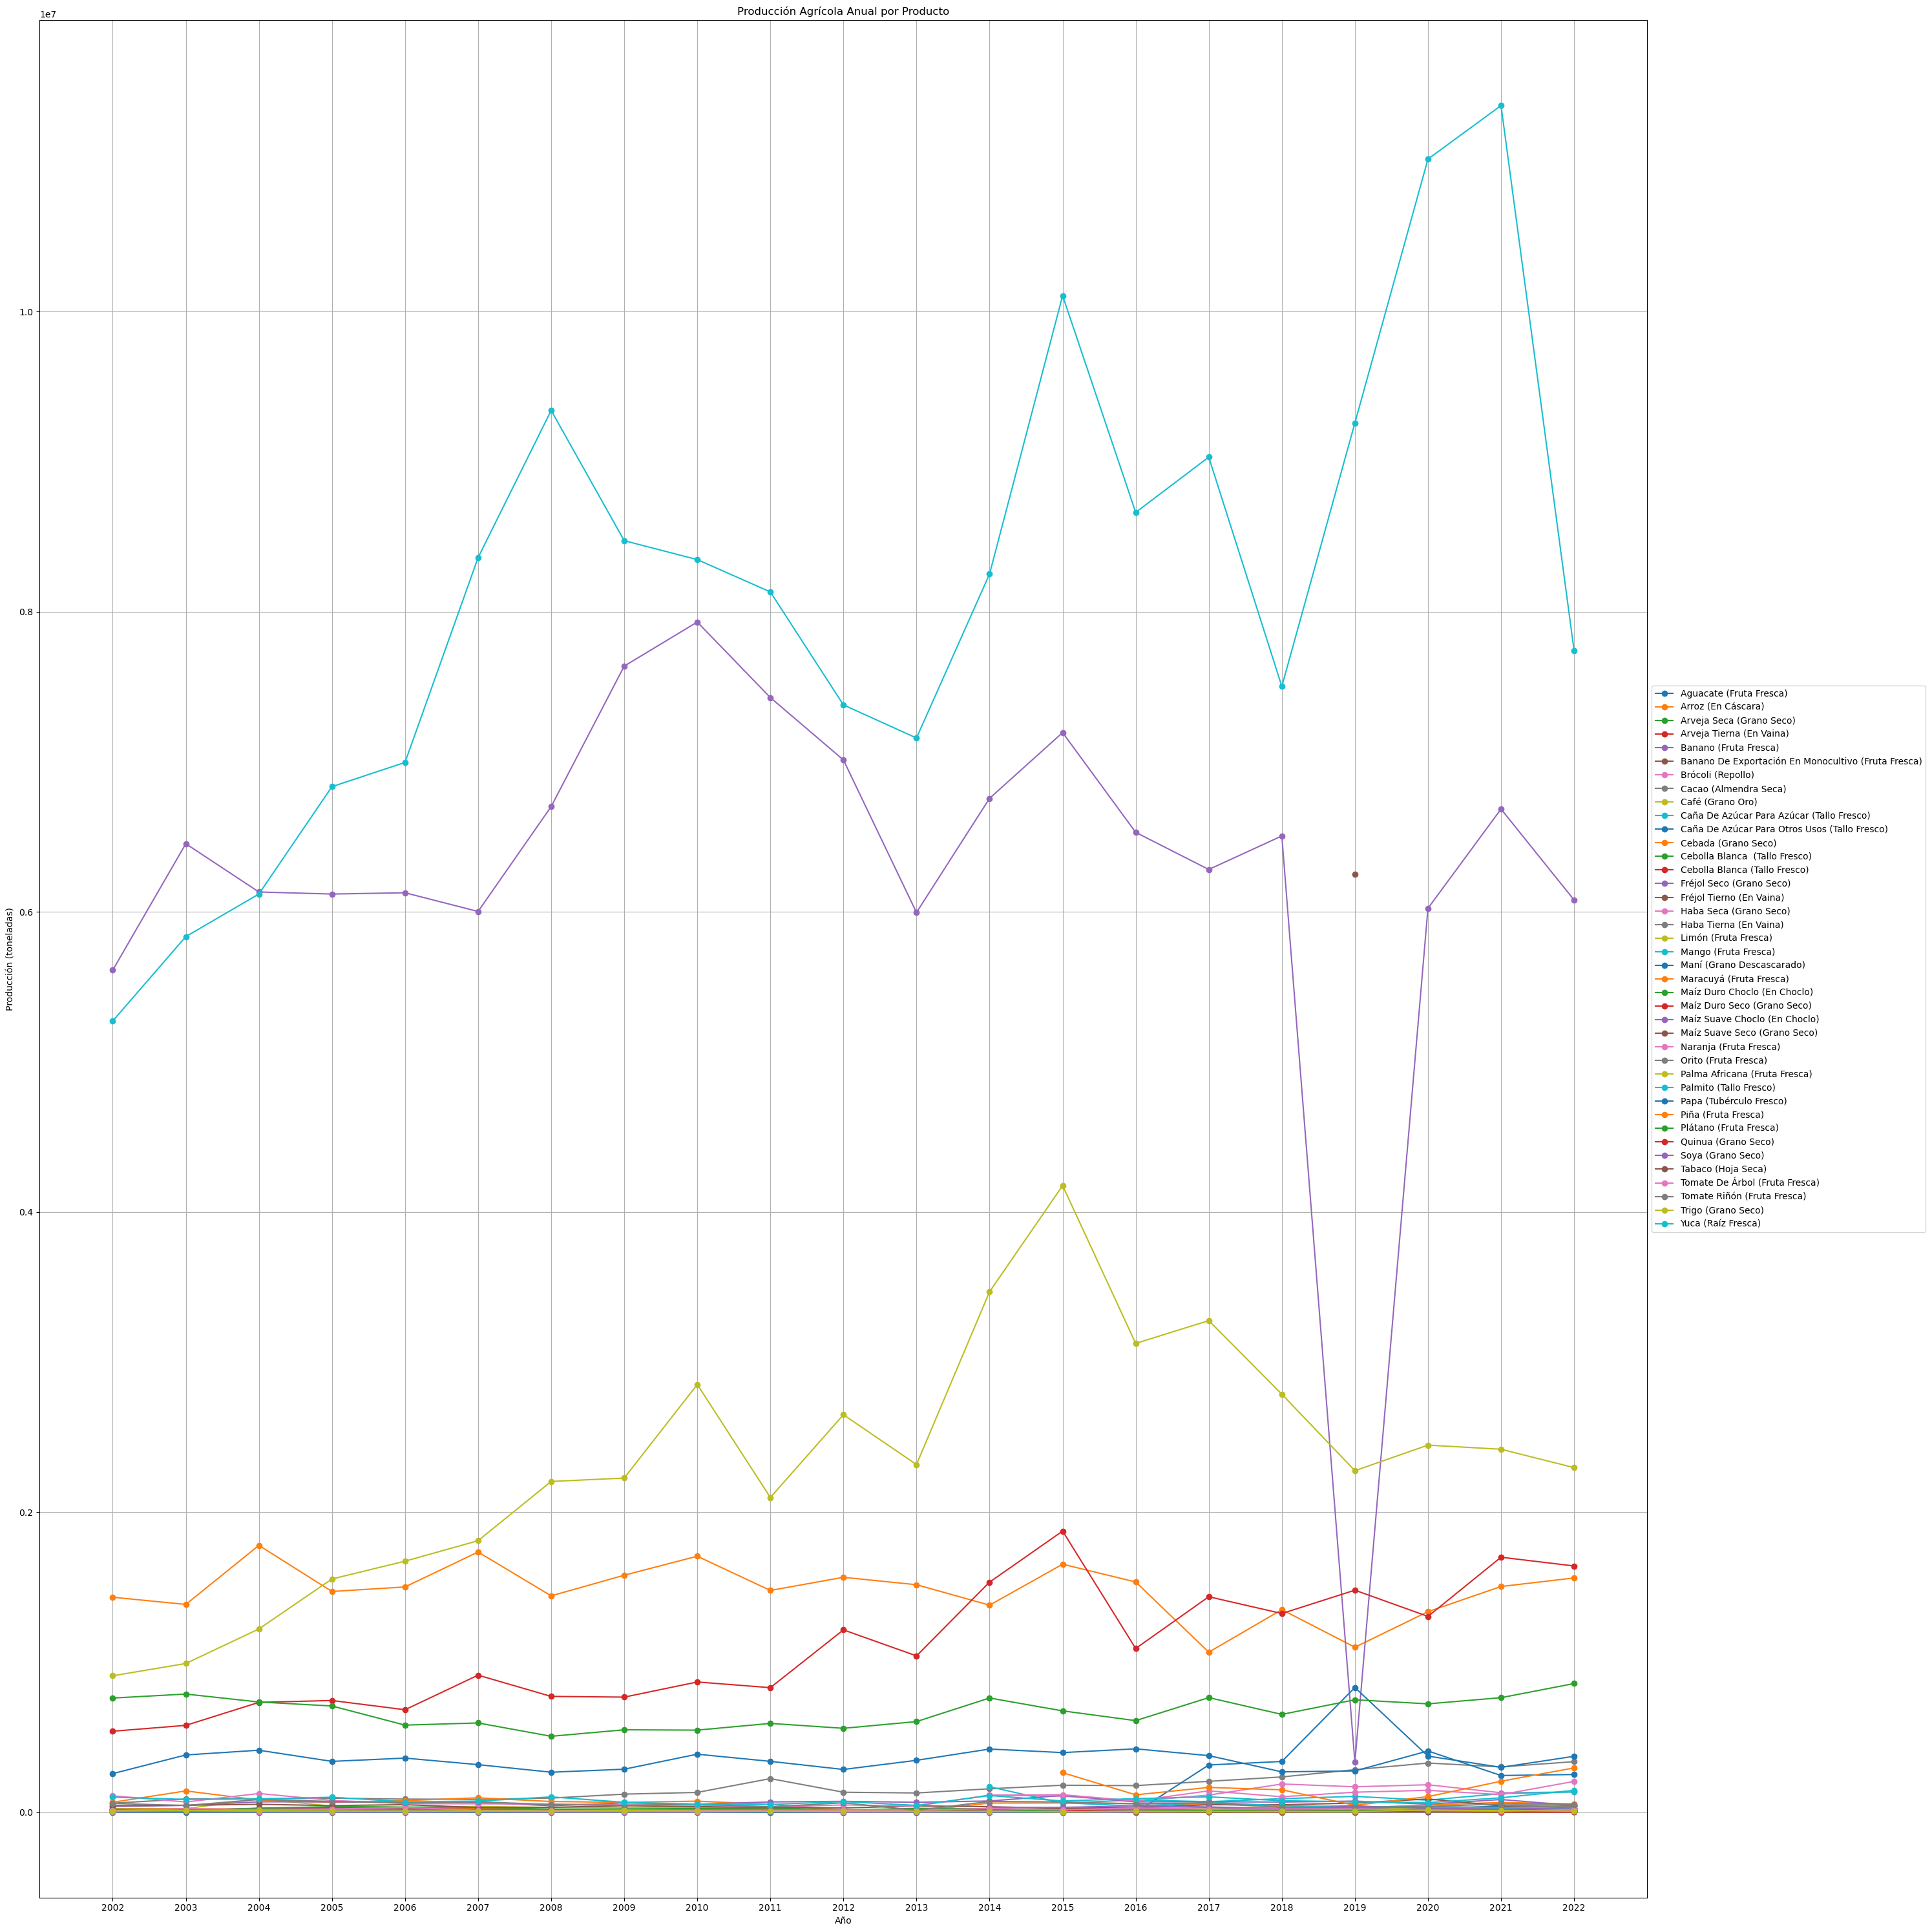

In [282]:
# Crear el gráfico
plt.figure(figsize=(30, 30))

# Iterar sobre cada producto único para trazar una línea
for producto in producción_agrícola_anual['Producto'].unique():
    subset = producción_agrícola_anual[producción_agrícola_anual['Producto'] == producto]
    plt.plot(subset['Año'], subset['Producción (toneladas)'], marker='o', label=producto)

# Configuración del gráfico
plt.title('Producción Agrícola Anual por Producto')
plt.xlabel('Año')
plt.ylabel('Producción (toneladas)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Añadir leyenda
plt.grid(True)
plt.xticks(producción_agrícola_anual['Año'].unique())
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [305]:
ranking_productos = producción_agrícola_anual\
    .groupby('Producto')\
        [vars_producción_num]\
        .sum()\
    .reset_index()\
    .sort_values(by='Producción (toneladas)', ascending=True)\
    .reset_index()\
    .drop(columns=['index'])


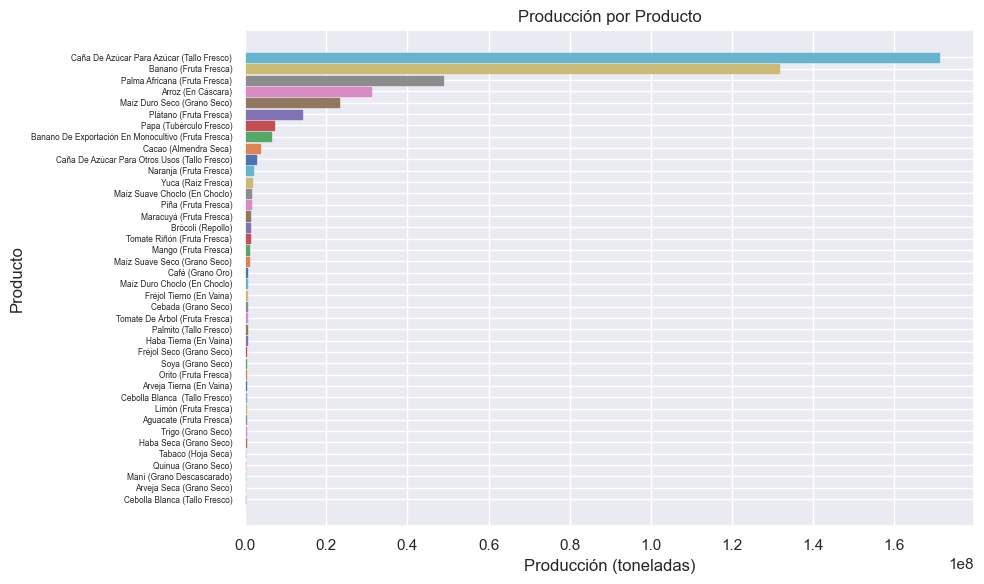

In [313]:
# Crear el gráfico
# Establecer el estilo de seaborn para afectar a matplotlib
sns.set(style="darkgrid")

# Crear el gráfico utilizando matplotlib
plt.figure(figsize=(10, 6))

# Utilizar una paleta de colores de seaborn
palette = sns.color_palette(None, len(ranking_productos['Producto']))

bars = plt.barh(ranking_productos['Producto'], ranking_productos['Producción (toneladas)'], color=palette)

# Añadir etiquetas y título
plt.xlabel('Producción (toneladas)')
plt.ylabel('Producto')
plt.title('Producción por Producto')

# Añadir leyenda manualmente utilizando la paleta de colores
for idx, bar in enumerate(bars):
    bar.set_color(palette[idx])

plt.yticks(size=6)
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()